# Object Detector Demo

After frames are retrieved from the dataset (`utils.dataset.aircraft_camera_data`), planes in said frame can be detected using pretrained YOLOv7 model and the AutoSegmentation process. This notebook will demonstrate the high-level usage of this object detection process.

AutoSegmentation process is needed for detecting small object in high-resolution images since pretrained YOLOv7 is trained on 640x640x3 images.

Frames received must be in a resolution of **(*n* x 640, *m* x 640)** in this case, in this case *n* = 2, *m* = 3 (hence  1280, 1920 size)

In [1]:
from utils.dataset import aircraft_camera_data
from utils.weather_modification import *
import utils.object_detector as od
import matplotlib.pyplot as plt
import torch
import pickle as pkl
import os

In [2]:
t = 1 # Time - 5
w = 4 # Weather - 5
r = 2 # Runs - 3

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

In [3]:
# Initialize Object Detector Class
mod = od.main_object_detector()

AutoSegmentation : 25.08 ms
Final Inference  : 6.99 ms
Post-Porcessing  : 0.29 ms
Total Time       : 32.36 ms


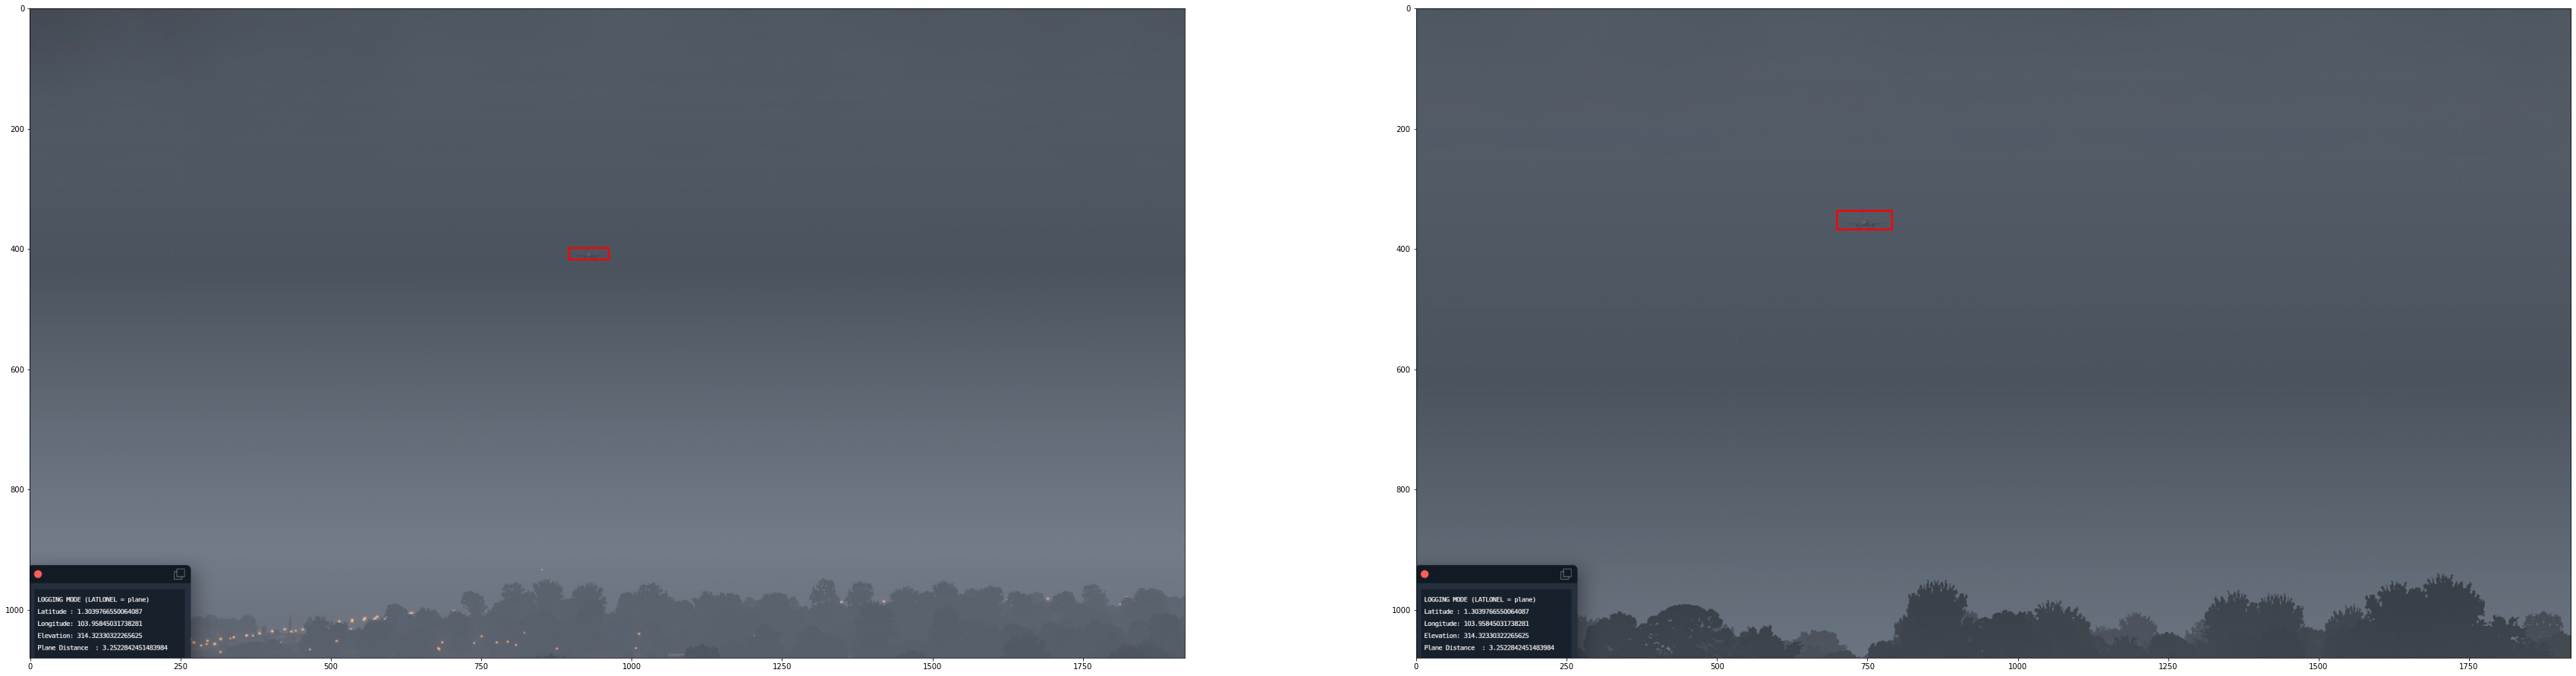

In [11]:
# Getting Frame from Video
n = 4500 # Change This
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1).cuda()

# Inferencing using optimized YOLO
box, score = mod.infer(img, association_function = od.example_association_function)

fig, ax = plt.subplots(1, 2,figsize = (60,60))
fig, ax = mod.vis(img[:, :, :1080], box, fig, ax)

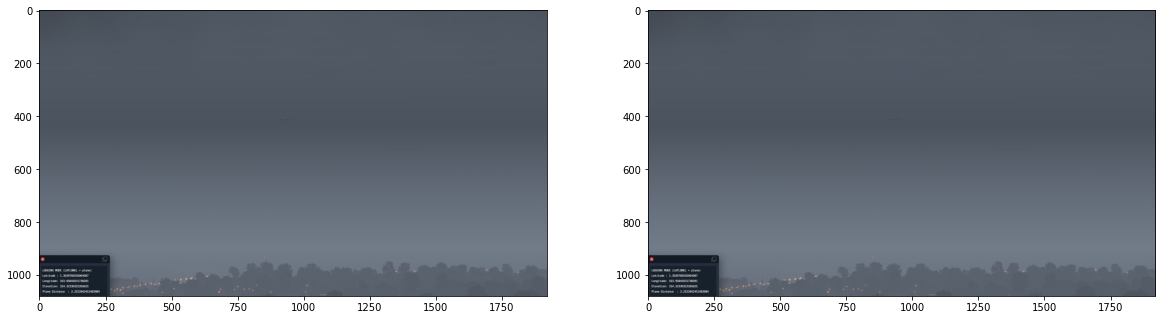

In [12]:
# Getting Frame from Video
n = 4500
img = acd.get_frame_from_video(n, size = (1080, 1920), batch_size = 1)[0].numpy()

# Plotting the Image
fig, ax = plt.subplots(1, 2, figsize = (20,20))
ax[0].imshow(img[0])
ax[1].imshow(img[0])

AutoSegmentation : 24.81 ms
Final Inference  : 0.05 ms
Post-Porcessing  : 0.34 ms
Total Time       : 25.20 ms


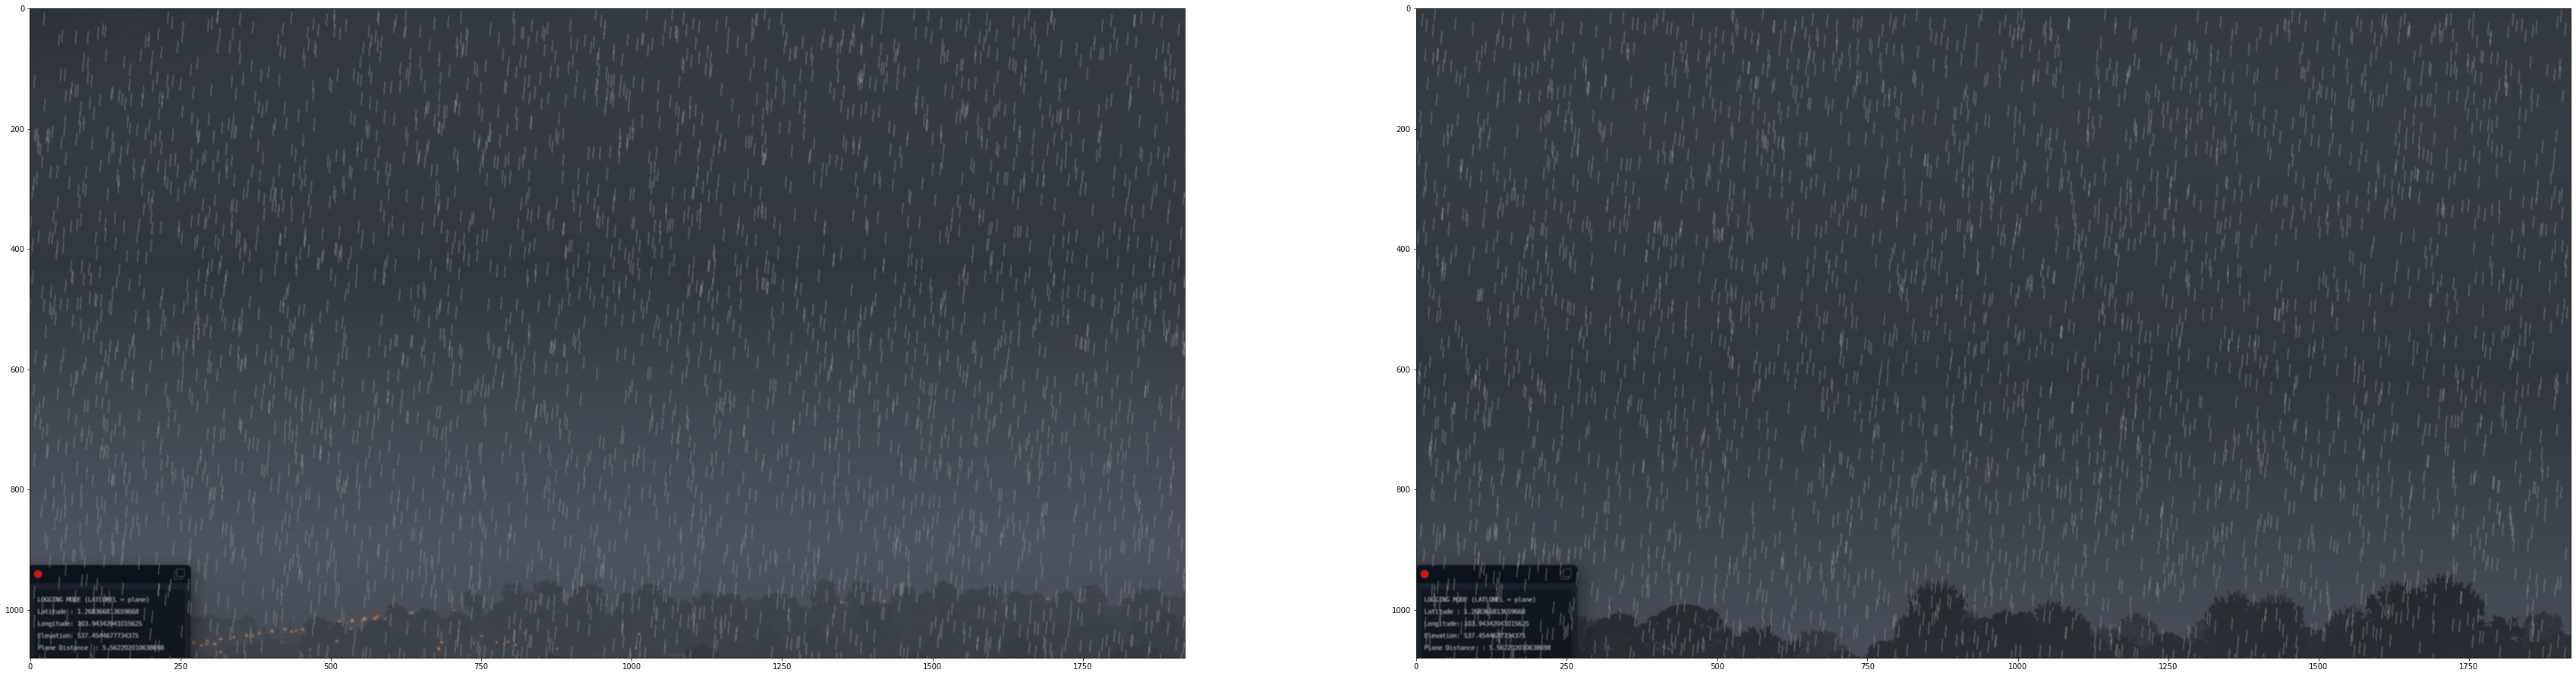

In [14]:
# Adding Weather Condition (Optional)
n = 3000 # Change This
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1)

img[0, 0] = torch.tensor(add_rain(img[0, 0].numpy(), drop_color=(0.78, 0.78, 0.78)))
img[0, 1] = torch.tensor(add_rain(img[0, 1].numpy(), drop_color=(0.78, 0.78, 0.78)))

box, score = mod.infer(img.cuda(), association_function = od.example_association_function)

fig, ax = plt.subplots(1, 2,figsize = (60,60))
fig, ax = mod.vis(img[:, :, :1080], box, fig, ax)

# Detecting All Frames in the dataset

All frames in an `aircraft_camera_dataset` object can be detected using `main_object_detector.infer_acd()` method.<br> 
A new folder will be created in `output/object_detector/` folder where pickled **bounding boxes, detections scores, and ground truth distance** will be stored.

Note that This process might take a while to complete.

In [2]:
from utils.dataset import aircraft_camera_data
from utils.weather_modification import *
import utils.object_detector_new as od
import matplotlib.pyplot as plt
import torch
import pickle as pkl

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"

mod = od.main_object_detector()

def association_function(final_box, final_score):
    empty_box = torch.zeros((1,4), device = final_box[0][0].device)
    empty_score = torch.zeros((1), device = final_score[0][0].device)
    associated_box = []
    associated_score = []
    for batch in range(len(final_box)):
        current_batch_box = []
        current_batch_score = []
        for cam in range(len(final_box[batch])):
            ff = [final_box[batch][cam][:, 1] < 910]
            temp_box = final_box[batch][cam][ff]
            temp_score = final_score[batch][cam][ff]
            
            if len(temp_box) == 0:
                current_batch_box.append(empty_box)
                current_batch_score.append(empty_score)
            else: 
                current_batch_box.append(temp_box[:1])
                current_batch_score.append(temp_score[:1])
        try:
            associated_box.append(torch.cat(current_batch_box, dim = 1))
            associated_score.append(torch.stack(current_batch_score, dim = 1))
        except:
            print(current_batch_score, "\n", current_batch_box,"\n", final_score[batch], "\n", final_box[batch])
            raise RuntimeError
                         
    return associated_box, associated_score

In [9]:
t = 1 # Time - 5
w = 5 # Weather - 5
r = 1 # Runs - 3

data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

box, scores = mod.infer_acd(acd, association_function=association_function)
gt_distance = acd.compute_dtt()
filename = f"output/object_detector_new/t{t}w{w}r{r}.pkl"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pkl.dump((box, scores, gt_distance), f)

100%|█████████████████████████████████████████████████████████| 6016/6016 [00:01<00:00, 3028.53it/s]


In [9]:
for t in range(1, 6):
    for w in range(1, 6):
        for r in range(1, 4):
            #print(f"Processing Data: t:{t} w:{w} r:{r}")
            data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl',
                             f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]
            # Dataset Class Initialization
            acd = aircraft_camera_data(
                data_sources=data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)
            
            box, score = mod.infer_acd(acd = acd, association_function = association_function, desc = f"Processing Data: t:{t} w:{w} r:{r}")
            gt_distance = acd.compute_dtt()
            filename = f"output/object_detector_new/t{t}w{w}r{r}.pkl"
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, 'wb') as f:
                pkl.dump((box, scores, gt_distance), f)
            print("")

100%|█████████████████████████████████████████████████████████| 6750/6750 [00:02<00:00, 2743.38it/s]


100%|█████████████████████████████████████████████████████████| 6819/6819 [00:02<00:00, 2957.36it/s]


100%|█████████████████████████████████████████████████████████| 6583/6583 [00:02<00:00, 2883.82it/s]


100%|█████████████████████████████████████████████████████████| 6750/6750 [00:02<00:00, 2771.61it/s]


100%|█████████████████████████████████████████████████████████| 6819/6819 [00:02<00:00, 2950.10it/s]


100%|█████████████████████████████████████████████████████████| 6583/6583 [00:02<00:00, 2813.72it/s]


100%|█████████████████████████████████████████████████████████| 6750/6750 [00:02<00:00, 2773.50it/s]


100%|█████████████████████████████████████████████████████████| 6819/6819 [00:02<00:00, 2883.63it/s]


100%|█████████████████████████████████████████████████████████| 6583/6583 [00:02<00:00, 2898.46it/s]


100%|█████████████████████████████████████████████████████████| 6750/6750 [00:02<00:00, 2962.70it/s]


100%|█████████████████████████████████████████████████████████| 6819/6819 [00:02<00:00, 2862.36it/s]


100%|█████████████████████████████████████████████████████████| 6629/6629 [00:02<00:00, 2827.59it/s]


100%|█████████████████████████████████████████████████████████| 6767/6767 [00:02<00:00, 2873.01it/s]


100%|█████████████████████████████████████████████████████████| 6979/6979 [00:02<00:00, 2869.46it/s]


100%|█████████████████████████████████████████████████████████| 6629/6629 [00:02<00:00, 2895.76it/s]


100%|█████████████████████████████████████████████████████████| 6767/6767 [00:02<00:00, 2839.92it/s]


100%|█████████████████████████████████████████████████████████| 6979/6979 [00:02<00:00, 2818.04it/s]


100%|█████████████████████████████████████████████████████████| 6629/6629 [00:02<00:00, 2940.69it/s]


100%|█████████████████████████████████████████████████████████| 6767/6767 [00:02<00:00, 2954.95it/s]


100%|█████████████████████████████████████████████████████████| 6979/6979 [00:02<00:00, 2719.99it/s]


100%|█████████████████████████████████████████████████████████| 6629/6629 [00:02<00:00, 2868.94it/s]


100%|█████████████████████████████████████████████████████████| 6767/6767 [00:02<00:00, 2826.90it/s]


100%|█████████████████████████████████████████████████████████| 6979/6979 [00:02<00:00, 2778.60it/s]


100%|█████████████████████████████████████████████████████████| 6629/6629 [00:02<00:00, 2763.22it/s]


100%|█████████████████████████████████████████████████████████| 6767/6767 [00:02<00:00, 2823.52it/s]


100%|█████████████████████████████████████████████████████████| 6979/6979 [00:02<00:00, 3039.32it/s]


100%|█████████████████████████████████████████████████████████| 7096/7096 [00:02<00:00, 3024.98it/s]


100%|█████████████████████████████████████████████████████████| 6552/6552 [00:02<00:00, 2953.02it/s]


100%|█████████████████████████████████████████████████████████| 6611/6611 [00:02<00:00, 3065.63it/s]


100%|█████████████████████████████████████████████████████████| 7096/7096 [00:02<00:00, 2981.56it/s]


100%|█████████████████████████████████████████████████████████| 6552/6552 [00:02<00:00, 3051.48it/s]


100%|█████████████████████████████████████████████████████████| 6611/6611 [00:02<00:00, 2912.39it/s]


100%|█████████████████████████████████████████████████████████| 7096/7096 [00:02<00:00, 3049.60it/s]


100%|█████████████████████████████████████████████████████████| 6552/6552 [00:02<00:00, 3106.28it/s]


100%|█████████████████████████████████████████████████████████| 6611/6611 [00:02<00:00, 3117.07it/s]


100%|█████████████████████████████████████████████████████████| 7096/7096 [00:02<00:00, 3012.82it/s]


100%|█████████████████████████████████████████████████████████| 6552/6552 [00:02<00:00, 3102.28it/s]


100%|█████████████████████████████████████████████████████████| 6611/6611 [00:02<00:00, 3080.14it/s]


100%|█████████████████████████████████████████████████████████| 7096/7096 [00:02<00:00, 3054.62it/s]


100%|█████████████████████████████████████████████████████████| 6552/6552 [00:02<00:00, 3121.56it/s]


100%|█████████████████████████████████████████████████████████| 6611/6611 [00:02<00:00, 3122.81it/s]


In [2]:
for t in range(1, 6):
    for w in range(1, 6):
        for r in range(1, 4):
            filename = f"output/object_detector_new/t{t}w{w}r{r}.pkl"
            print(f"Processing Data: t:{t} w:{w} r:{r}")
            with open(filename, 'rb') as f:
                box, scores, gt_distance = pkl.load(f)
            box = box.cpu()
            scores = scores.cpu()
            gt_distance = gt_distance[:box.shape[0]]
            with open(filename, 'wb') as f:
                pkl.dump((box, scores, gt_distance), f)

Processing Data: t:1 w:1 r:1
Processing Data: t:1 w:1 r:2
Processing Data: t:1 w:1 r:3
Processing Data: t:1 w:2 r:1
Processing Data: t:1 w:2 r:2
Processing Data: t:1 w:2 r:3
Processing Data: t:1 w:3 r:1
Processing Data: t:1 w:3 r:2
Processing Data: t:1 w:3 r:3
Processing Data: t:1 w:4 r:1
Processing Data: t:1 w:4 r:2
Processing Data: t:1 w:4 r:3
Processing Data: t:1 w:5 r:1
Processing Data: t:1 w:5 r:2
Processing Data: t:1 w:5 r:3
Processing Data: t:2 w:1 r:1
Processing Data: t:2 w:1 r:2
Processing Data: t:2 w:1 r:3
Processing Data: t:2 w:2 r:1
Processing Data: t:2 w:2 r:2
Processing Data: t:2 w:2 r:3
Processing Data: t:2 w:3 r:1
Processing Data: t:2 w:3 r:2
Processing Data: t:2 w:3 r:3
Processing Data: t:2 w:4 r:1
Processing Data: t:2 w:4 r:2
Processing Data: t:2 w:4 r:3
Processing Data: t:2 w:5 r:1
Processing Data: t:2 w:5 r:2
Processing Data: t:2 w:5 r:3
Processing Data: t:3 w:1 r:1
Processing Data: t:3 w:1 r:2
Processing Data: t:3 w:1 r:3
Processing Data: t:3 w:2 r:1
Processing Dat

# Visualizing Detections

In [1]:
from utils.dataset import aircraft_camera_data
import pickle as pkl
import tqdm.auto as tqdm
import cv2
import numpy as np

In [2]:
for t in range(2,3):
    for w in range(3,4):
        for r in range(2,3):
            output_video = f'output/old_vs_new/t{t}w{w}r{r}.mp4'

            data_indexes = [1,2] # Camera 1 & 2
            touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
            dataset_directory = "/media/gabriel/DATA/dataset"

            data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

            # Dataset Class Initialization
            acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

            with open(f"output/object_detector/t{t}w{w}r{r}.pkl", "rb") as f:
                box, scores, gt_distance = pkl.load(f)
            with open(f"output/object_detector_old/t{t}w{w}r{r}.pkl", "rb") as f:
                box_old, scores_old, gt_distance_old = pkl.load(f)

            fourcc = cv2.VideoWriter_fourcc(*'MP4V')
            out = cv2.VideoWriter(f'{output_video}', fourcc, 30.0, (1920, 2160))

            for index in tqdm.trange(min(acd.video_length)):
                frames = [i.read()[1] for i in acd.vidcap]

                for j, frame in enumerate(frames):
                    curr_box = np.array(box[index][j*4: j*4 + 4])
                    curr_box_old = np.array(box_old[index][j*4: j*4 + 4])

                    c1 = (int(curr_box_old[0]), int(curr_box_old[1]))
                    c2 = (int(curr_box_old[2]), int(curr_box_old[3]))
                    color = [0,0,255]
                    cv2.rectangle(frame, c1, c2, color, thickness=1, lineType=cv2.LINE_AA)

                    c1 = (int(curr_box[0]), int(curr_box[1]))
                    c2 = (int(curr_box[2]), int(curr_box[3]))
                    color = [255,0,0]
                    cv2.rectangle(frame, c1, c2, color, thickness=1, lineType=cv2.LINE_AA)
                out.write(np.concatenate(frames))
            out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/6262 [00:00<?, ?it/s]